<a href="https://colab.research.google.com/github/davideneffat/movie_recommendations/blob/main/movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Graph representation learning with node2vec

In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Download the MovieLens dataset and prepare the data


In [ ]:
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-20m.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

In [ ]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [ ]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

Construct the Movies graph


We create an edge between two movie nodes in the graph if both movies are rated by the same user >= min_rating. The weight of the edge will be based on the pointwise mutual information between the two movies, which is computed as: log(xy) - log(x) - log(y) + log(D), where:


*   xy is how many users rated both movie x and movie y with >= min_rating.
*   x is how many users rated movie x >= min_rating.
*   y is how many users rated movie y >= min_rating.
*   D total number of movie ratings >= min_rating.

In [ ]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))
# Iterate through user groups to compute movie rating frequencies and pair frequencies.
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    # Update item frequency for each movie.
    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1

        # Update pair frequency for each pair of movies rated by the user.
        for j in range(i + 1, len(current_movies)):
            # Ensure consistent ordering of movie pairs (x, y) and (y, x).
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 685.96it/s]


In [ ]:
min_weight = 10 #to reduce the num of nodes we only use nodes weighted at least min_weight
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
movies_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]

    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D  #Pointwise Mutual Information PMI

    weight = pmi * xy_frequency

    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 353674.63it/s]


In [ ]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [ ]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 57.0


Create vocabulary and a mapping from tokens to integer indices

In [ ]:
# Include a special token for unknown nodes (NA)
vocabulary = ["NA"] + list(movies_graph.nodes)
# Create a mapping from tokens to integer indices
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}
#dictionary where the keys are the movie IDs (nodes), and the values are the corresponding integer indices in the vocabulary list

Implement the biased random walk


In [ ]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)

            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

Generate training data using the biased random walk


In [ ]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:07<00:00, 198.48it/s]

Number of walks generated: 7025


Generate positive and negative examples


*   **target**: A movie in a walk sequence. (movie for which you want to predict related movies)
*   **context**: Another movie in a walk sequence.
*   **weight**: How many times these two movies occured in walk sequences.
*   **label**: The label is 1 if these two movies are samples from the walk sequences, otherwise (i.e., if randomly sampled) the label is 0.

In [ ]:
#takes a list of sequences (walks) and generates positive and negative skip-gram pairs for training a skip-gram model
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )

        #Iterate through the generated skip-gram pairs
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context: #ensuring that the target and context are not the same
                continue
            entry = (target, context, label)
            example_weights[entry] += 1 #Update the defaultdict with the count of occurrences for each skip-gram pair

    targets, contexts, labels, weights = [], [], [], []

    #Collect the target movies, context movies, labels, and weights from the defaultdict into lists
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:14<00:00, 483.41it/s]


In [ ]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

Targets shape: (883709,)
Contexts shape: (883709,)
Labels shape: (883709,)
Weights shape: (883709,)


Convert the data into tf.data.Dataset objects


In [ ]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {  #dictionary
        "target": targets,
        "context": contexts,
    }

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2) #Shuffle
    dataset = dataset.batch(batch_size, drop_remainder=True)  #Batch
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  #allow the data loading pipeline to asynchronously fetch batches while the model is training
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

Train the skip-gram model


Our skip-gram is a simple binary classification model that works as follows:

1.   An embedding is looked up for the target movie.
2.   An embedding is looked up for the context movie.
3.   The dot product is computed between these two embeddings.
4.   The result (after a sigmoid activation) is compared to the label.
5.   A binary crossentropy loss is used.

In [ ]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [ ]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])

    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

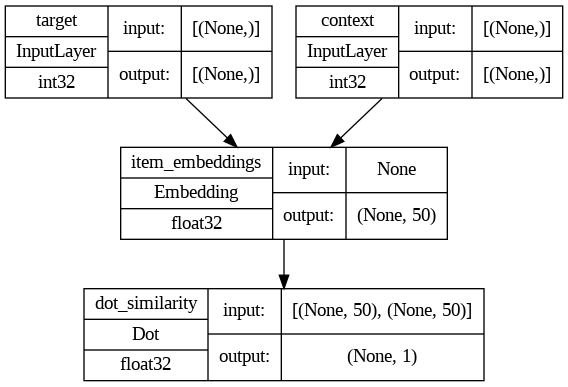

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

Now we train the model on the dataset.



In [ ]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
862/862 [==============================] - 8s 8ms/step - loss: 2.4489
Epoch 2/10
862/862 [==============================] - 9s 10ms/step - loss: 2.3419
Epoch 3/10
862/862 [==============================] - 9s 10ms/step - loss: 2.3324
Epoch 4/10
862/862 [==============================] - 7s 8ms/step - loss: 2.3273
Epoch 5/10
862/862 [==============================] - 7s 8ms/step - loss: 2.3224
Epoch 6/10
862/862 [==============================] - 9s 10ms/step - loss: 2.3182
Epoch 7/10
862/862 [==============================] - 9s 10ms/step - loss: 2.3150
Epoch 8/10
862/862 [==============================] - 7s 9ms/step - loss: 2.3123
Epoch 9/10
862/862 [==============================] - 7s 8ms/step - loss: 2.3098
Epoch 10/10
862/862 [==============================] - 9s 10ms/step - loss: 2.3075


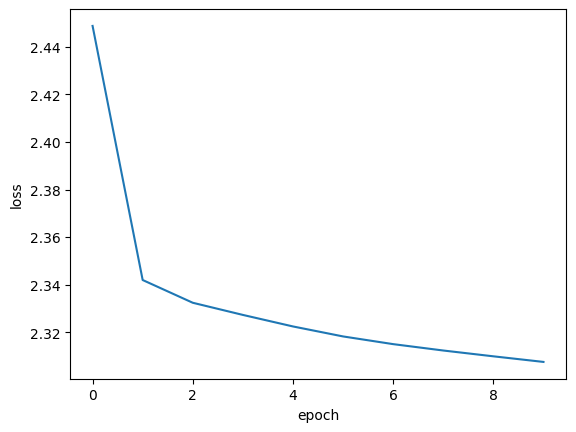

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

Analyze the learnt embeddings.


In [ ]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (1406, 50)


Find related movies


In [ ]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

In [ ]:
#Get the embeddings of the movies in query_movies.
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [ ]:
#Compute the consine similarity between the embeddings of query_movies and all the other movies, then pick the top k for each.

similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [ ]:
#Display the top related movies in query_movies.

for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

Matrix, The (1999)
------------------
- Lord of the Rings: The Fellowship of the Ring, The (2001)
- Matrix, The (1999)
- Lord of the Rings: The Return of the King, The (2003)
- Fight Club (1999)
- Pulp Fiction (1994)

Star Wars: Episode IV - A New Hope (1977)
-----------------------------------------
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Terminator 2: Judgment Day (1991)
- Pulp Fiction (1994)
- Matrix, The (1999)
- Star Wars: Episode V - The Empire Strikes Back (1980)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Independence Day (a.k.a. ID4) (1996)
- Beauty and the Beast (1991)
- Aladdin (1992)
- Apollo 13 (1995)

Terminator 2: Judgment Day (1991)
---------------------------------
- Terminator 2: Judgment Day (1991)
- Forrest Gump (1994)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
- Braveheart (1995)
- Pulp Fiction (1994)

Godfather, The (1972)
---------------------
- Godfather, 

In [ ]:
def get_high_rated_movies(user_id, threshold):  #filter movies with high rating from that user
    user_movies = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= threshold)]['movieId'].tolist()
    return user_movies

user_id = 1 #input

query_movies = get_high_rated_movies(user_id, 5.0)
print(f"Movies rated at least 5.0 by user {user_id}: {query_movies}")

if(not query_movies): #no movies reviewed as 5.0 by the user: let's take lower reviewed movies
  query_movies = get_high_rated_movies(user_id, 3.0)

query_movies = [element for element in query_movies if element in movies_graph.nodes()] #some movies are not present since not connected with other movies

if(not query_movies):
  print("This user has not reviewed enough movies")
  raise SystemExit("Stop right there!")

#Get the embeddings of the movies in query_movies.
query_embeddings = []

for movieId in query_movies:  #calculate embeddings for the high-rated movies seen by the user
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

#Compute the consine similarity between the embeddings of query_movies and all the other movies, then pick the top k for each.
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

movie_rank_for_user = []

#Display the top related movies in query_movies.
for idx, id in enumerate(query_movies):
    title = get_movie_title_by_id(id)
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")

        movie_rank_for_user.append(token) #add all similar movies to this list

    print()


from collections import Counter
#get the most common similar movie
counter = Counter(movie_rank_for_user)

# Sort elements by frequency (most common first)
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# Extract the elements from the sorted list
most_present_elements = [element for element, _ in sorted_elements]


for id in most_present_elements:
  movieId = vocabulary[id]
  if(ratings[(ratings['userId'] == user_id) & (ratings['movieId'] == movieId)].empty):  #movie not yet watched: we can recommend it
    title = get_movie_title_by_id(movieId)
    print(f"We suggest User_{user_id} to watch {title} as next movie")
    break

Movies rated at least 5.0 by user 1: ['movie_47', 'movie_50', 'movie_101', 'movie_151', 'movie_157', 'movie_163', 'movie_216', 'movie_231', 'movie_260', 'movie_333', 'movie_362', 'movie_457', 'movie_527', 'movie_553', 'movie_596', 'movie_608', 'movie_661', 'movie_919', 'movie_923', 'movie_940', 'movie_954', 'movie_1023', 'movie_1024', 'movie_1025', 'movie_1029', 'movie_1031', 'movie_1032', 'movie_1049', 'movie_1073', 'movie_1080', 'movie_1089', 'movie_1092', 'movie_1097', 'movie_1136', 'movie_1196', 'movie_1197', 'movie_1198', 'movie_1206', 'movie_1210', 'movie_1213', 'movie_1220', 'movie_1222', 'movie_1224', 'movie_1226', 'movie_1240', 'movie_1256', 'movie_1270', 'movie_1275', 'movie_1278', 'movie_1282', 'movie_1291', 'movie_1298', 'movie_1517', 'movie_1573', 'movie_1587', 'movie_1617', 'movie_1625', 'movie_1732', 'movie_1804', 'movie_1927', 'movie_1954', 'movie_2005', 'movie_2018', 'movie_2033', 'movie_2048', 'movie_2058', 'movie_2078', 'movie_2090', 'movie_2094', 'movie_2115', 'movi